# Baseline Models for Theme Park Wait Time Prediction

This script implements various baseline models to compare with the Prophet model for
predicting wait times at theme park attractions.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define consistent colors for plots
TRAIN_COLOR = 'steelblue'
TRAIN_FILL_COLOR = 'steelblue'
TRAIN_FILL_ALPHA = 0.3
VAL_COLOR = 'coral'
VAL_FILL_COLOR = 'coral'
VAL_FILL_ALPHA = 0.3

## Data Loading and Initial Preprocessing

We'll use the same preprocessing as the Prophet model for consistency.

In [9]:
def load_data(file_path):
    data = pd.read_parquet(file_path)
    return data

def add_features(data):
    data['hour'] = data['timestamp'].dt.hour
    data['minute'] = data['timestamp'].dt.minute
    data['time_key'] = data['hour'] * 60 + data['minute']
    data['day_of_week'] = data['timestamp'].dt.dayofweek
    data['month'] = data['timestamp'].dt.month
    data['time_key'] = data['hour'] * 60 + data['minute']
    return data

def check_for_missing_values(data):
    missing_values = data.isnull().sum()
    if missing_values.any():
        print("Missing values found in the dataset:")
        print(missing_values[missing_values > 0])
    else:
        print("No missing values found in the dataset.")
    return missing_values

def split_data(data, train_years, val_year, test_year):
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    
    train_data = data[data['timestamp'].dt.year.isin(train_years)]
    val_data = data[data['timestamp'].dt.year == val_year]
    test_data = data[data['timestamp'].dt.year == test_year]
    
    print(f"Train data size: {len(train_data)}")
    print(f"Validation data size: {len(val_data)}")
    print(f"Test data size: {len(test_data)}")
    
    return train_data, val_data, test_data

def filter_ride_data(data, ride_name):
    return data[data[f'ride_name_{ride_name}'] == True].copy()

def get_all_rides(data):
    ride_columns = [col for col in data.columns if col.startswith('ride_name_')]
    return [col.replace('ride_name_', '') for col in ride_columns]

def filter_to_operating_hours(ride_data):
    # Determine operating hours from data where wait times > 0
    operating_hours = ride_data[ride_data["wait_time"] > 0].groupby(
        ride_data["timestamp"].dt.date
    )["timestamp"].agg(['min', 'max']).reset_index()
    
    # Extract opening and closing hours
    operating_hours['opening_hour'] = pd.to_datetime(operating_hours['min']).dt.hour
    operating_hours['closing_hour'] = pd.to_datetime(operating_hours['max']).dt.hour
    
    # Set reasonable boundaries for operating hours
    operating_hours['opening_hour'] = operating_hours['opening_hour'].clip(lower=9, upper=11)
    operating_hours['closing_hour'] = operating_hours['closing_hour'].clip(lower=17, upper=21)
    
    # Create date-to-hours mapping
    date_to_hours = {}
    for _, row in operating_hours.iterrows():
        date_to_hours[row['timestamp']] = (row['opening_hour'], row['closing_hour'])
    
    # Filter data to operating hours only
    def is_operating_hour(timestamp):
        date = timestamp.date()
        assert date in date_to_hours, f"Date {date} not found in operating hours mapping."
        
        open_hour, close_hour = date_to_hours[date]
        hour = timestamp.hour
        return 1 if open_hour <= hour < close_hour else 0
    
    ride_data['operating_hour'] = ride_data['timestamp'].apply(is_operating_hour)
    ride_data = ride_data[ride_data['operating_hour'] == 1]
    ride_data = ride_data.drop(columns=["operating_hour"])
    
    return ride_data

In [10]:
# Load the data
print("Loading data...")
data = load_data("../data/processed/ep/final_cleaned_processed_wait_times.parquet")
data = add_features(data)
print(f"Loaded data with {len(data)} rows")

check_for_missing_values(data)

data = filter_to_operating_hours(data)

ride_name = "silver star"
ride_df = filter_ride_data(data, ride_name)

# Define time periotimestamp for splitting
train_years, val_year, test_year = list(range(2017, 2023)), 2023, 2024

# Split the data
train_data, val_data, test_data = split_data(ride_df, train_years, val_year, test_year)

# Get all rides in the dataset
all_rides = get_all_rides(data)
print(f"Found {len(all_rides)} rides in the dataset:")
for i, ride in enumerate(all_rides):
    print(f"{i+1}. {ride}")

Loading data...
Loaded data with 7834739 rows
No missing values found in the dataset.
Train data size: 10244
Validation data size: 2064
Test data size: 1826
Found 31 rides in the dataset:
1. alpine express enzian
2. arena of football  be part of it
3. arthur
4. atlantica supersplash
5. atlantis adventure
6. baaa express
7. blue fire megacoaster
8. castello dei medici
9. dancing dingie
10. euromir
11. eurosat  cancan coaster
12. eurotower
13. fjordrafting
14. jim button  journey through morrowland
15. josefinas magical imperial journey
16. kolumbusjolle
17. madame freudenreich curiosits
18. matterhornblitz
19. old mac donalds tractor fun
20. pegasus
21. poppy towers
22. poseidon
23. silver star
24. swiss bob run
25. tirol log flume
26. vienna wave swing  glckspilz
27. vindjammer
28. voletarium
29. volo da vinci
30. voltron nevera powered by rimac
31. whale adventures  northern lights


In [11]:
train_data.head()

,timestamp,wait_time,closed,is_german_holiday,is_swiss_holiday,is_french_holiday,time_bucket,day_of_week,temperature,rain,...,year_2019,year_2020,year_2021,year_2022,year_2023,year_2024,hour,minute,time_key,month
5737257,2017-05-23 09:00:00,0.0,0,0,0,0,2017-05-23 09:00:00,1,0.629864,-0.208984,...,0.0,0.0,0.0,0.0,0.0,0.0,9,0,540,5
5737258,2017-05-23 10:00:00,10.0,0,0,0,0,2017-05-23 10:00:00,1,1.034136,-0.208984,...,0.0,0.0,0.0,0.0,0.0,0.0,10,0,600,5
5737259,2017-05-23 11:00:00,15.0,0,0,0,0,2017-05-23 11:00:00,1,1.389896,-0.208984,...,0.0,0.0,0.0,0.0,0.0,0.0,11,0,660,5
5737260,2017-05-23 12:00:00,15.0,0,0,0,0,2017-05-23 12:00:00,1,1.616288,-0.208984,...,0.0,0.0,0.0,0.0,0.0,0.0,12,0,720,5
5737261,2017-05-23 13:00:00,5.0,0,0,0,0,2017-05-23 13:00:00,1,1.810339,-0.208984,...,0.0,0.0,0.0,0.0,0.0,0.0,13,0,780,5


## Holiday Effects

We'll create the holiday dataframes.

In [12]:
def create_holiday_dataframes(data):
    holiday_dfs = []
    
    # Process country holidays
    for country in ['swiss', 'german', 'french']:
        holiday_col = f"is_{country}_holiday"
        if holiday_col in data.columns:
            country_holidays = data.loc[data[holiday_col] == 1, ["timestamp"]]
            if len(country_holidays) > 0:
                country_holidays["timestamp"] = pd.to_datetime(country_holidays["timestamp"]).dt.date
                country_holidays = country_holidays.drop_duplicates(subset=["timestamp"])
                country_holidays["holiday"] = f"{country}_holiday"
                holiday_dfs.append(country_holidays.reset_index(drop=True))
    # Combine all holidays
    if holiday_dfs:
        all_holidays = pd.concat(holiday_dfs)
        all_holidays["timestamp"] = pd.to_datetime(all_holidays["timestamp"])
        return all_holidays.sort_values(by=["timestamp"]).reset_index(drop=True)
    return None

# Create holiday dataframes
holidays_df = create_holiday_dataframes(ride_df)
print(f"Created holiday dataframe with {len(holidays_df)} entries")
holidays_df.head()

Created holiday dataframe with 189 entries


,timestamp,holiday
0,2017-05-25,swiss_holiday
1,2017-05-25,german_holiday
2,2017-05-25,french_holiday
3,2017-05-27,french_holiday
4,2017-06-05,swiss_holiday


## Helper Functions for Evaluation and Visualization

We'll use the same functions for evaluation and visualization as in the Prophet model.

In [13]:
def post_process_forecast(forecast, closed_data):
    """Apply corrections to forecasted values."""
    # Set predictions to zero during known closures
    closed_mask = forecast['timestamp'].isin(closed_data.loc[closed_data['closed'] == 1, 'timestamp'])
    forecast.loc[closed_mask, 'wait_time'] = 0
    
    # Correct negative predictions
    negative_mask = forecast['wait_time'] < 0
    forecast.loc[negative_mask, 'wait_time'] = 0
    
    return forecast

def evaluate_model(ride_df, actual_values, predictions, title=""):
    # Calculate metrics
    mae = np.mean(np.abs(predictions - actual_values))
    rmse = np.sqrt(np.mean(np.square(predictions - actual_values)))
    
    # For sMAPE, avoid division by zero
    epsilon = 1e-8
    abs_pct_errors = np.abs(predictions - actual_values) / (np.abs(predictions) + np.abs(actual_values) + epsilon)
    # Only include points where actual values are non-zero
    non_zero_mask = (actual_values > 0) & (predictions > 0)
    smape = np.mean(abs_pct_errors[non_zero_mask]) * 100

    # Print metrics
    print(f"\n{title} MAE: {mae:.2f} minutes")
    print(f"{title} RMSE: {rmse:.2f} minutes")
    print(f"{title} sMAPE: {smape:.2f}%")
    
    # Create a DataFrame with results for time-based analysis
    results_df = pd.DataFrame({
        'timestamp': ride_df['timestamp'].values,
        'actual': actual_values,
        'predicted': predictions,
    })
    
    # Add time components
    results_df['hour'] = results_df['timestamp'].dt.hour
    results_df['day_of_week'] = results_df['timestamp'].dt.dayofweek
    results_df['month'] = results_df['timestamp'].dt.month
    
    # Calculate errors
    results_df['error'] = results_df['predicted'] - results_df['actual']
    results_df['abs_error'] = np.abs(results_df['error'])
    results_df['pct_error'] = abs_pct_errors * 100
    
    # Visualize results
    fig, axes = plt.subplots(2, 1, figsize=(12, 16))
    
    # Actual vs Predicted scatter plot
    axes[0].scatter(actual_values, predictions, alpha=0.5)
    max_val = max(np.max(actual_values), np.max(predictions))
    axes[0].plot([0, max_val], [0, max_val], 'k--')
    axes[0].set_xlabel('Actual Wait Time (minutes)')
    axes[0].set_ylabel('Predicted Wait Time (minutes)')
    axes[0].set_title(f'{title} - Actual vs Predicted')
    
    # Hourly analysis
    hourly_errors = results_df.groupby('hour')['abs_error'].mean()
    hourly_errors.plot(kind='bar', ax=axes[1])
    axes[1].set_xlabel('Hour of Day')
    axes[1].set_ylabel('Mean Absolute Error (minutes)')
    axes[1].set_title(f'{title} - Error Analysis by Hour of Day')
    
    plt.tight_layout()
    
    # Create metrics dictionary
    metrics = {
        "mae": mae,
        "rmse": rmse,
        "smape": smape
    }
    
    return metrics, results_df, fig

## Baseline Model 1: Mean Baseline

This is the simplest baseline, predicting the mean value of the training data.

---- Training Mean Baseline Model ----

Mean Baseline Model MAE: 10.89 minutes
Mean Baseline Model RMSE: 13.65 minutes
Mean Baseline Model sMAPE: 25.21%


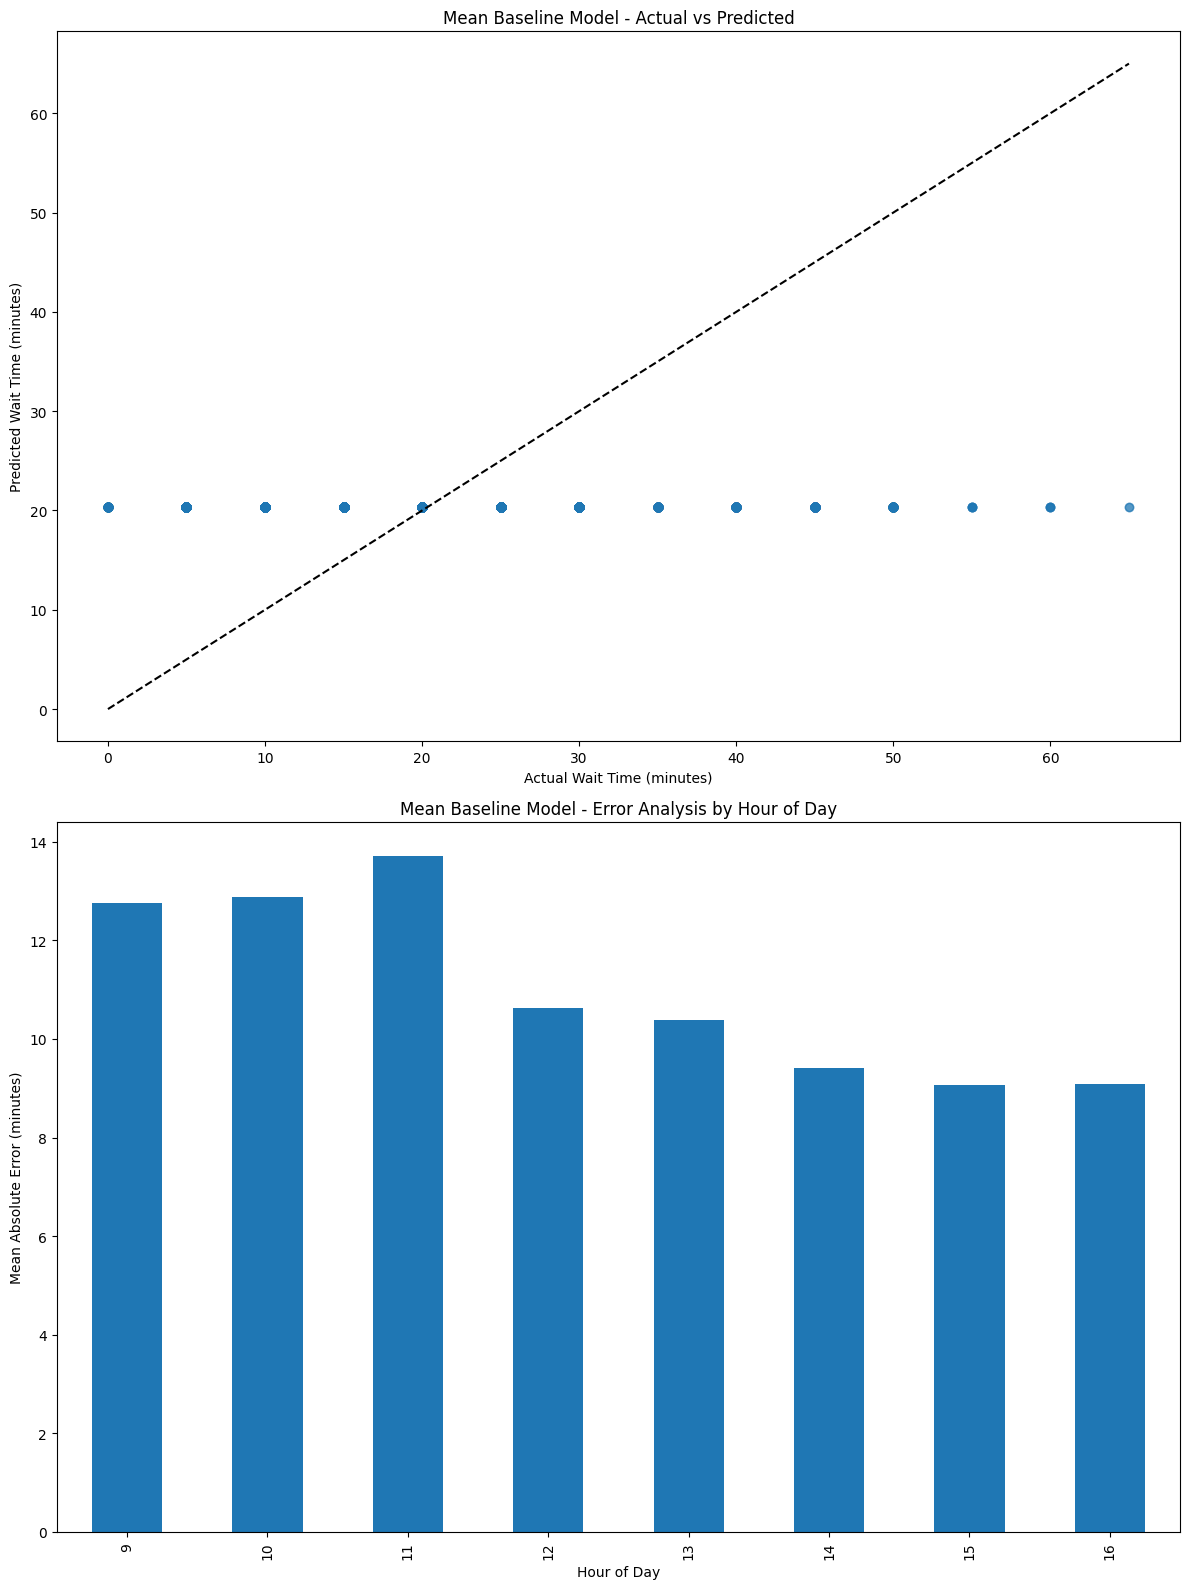

In [27]:
class MeanBaselineModel:
    """A simple baseline model that predicts the mean value of the training data."""
    def __init__(self):
        self.mean_value = None
        
    def fit(self, train_data):
        """Fit the model by calculating the mean of the training data"""
        self.mean_value = train_data['wait_time'].mean()
        return self
        
    def predict(self, future_df):
        """Predict using the mean value for all future points"""
        predictions = pd.DataFrame({'timestamp': future_df['timestamp']})
        predictions['yhat'] = self.mean_value
        return predictions

# Create future dataframe for predictions
future = pd.DataFrame({'timestamp': val_data['timestamp'].unique()})
future = future.sort_values('timestamp').reset_index(drop=True)

# Train and evaluate the Mean Baseline model
print("---- Training Mean Baseline Model ----")
mean_model = MeanBaselineModel()
mean_model.fit(train_data)
mean_forecast = mean_model.predict(future)
mean_forecast = post_process_forecast(mean_forecast, val_data)

val_actual = val_data['wait_time'].values
val_predictions = mean_forecast['yhat'].values

metrics, results_df, fig = evaluate_model(val_data, val_actual, val_predictions, title="Mean Baseline Model")
fig;

## Baseline Model 2: Time-of-Day Baseline

This model captures daily patterns by using the average wait time for each time of day based on training data.


---- Training Time-of-Day Baseline Model ----

Mean Baseline Model MAE: 9.46 minutes
Mean Baseline Model RMSE: 12.32 minutes
Mean Baseline Model sMAPE: 21.51%


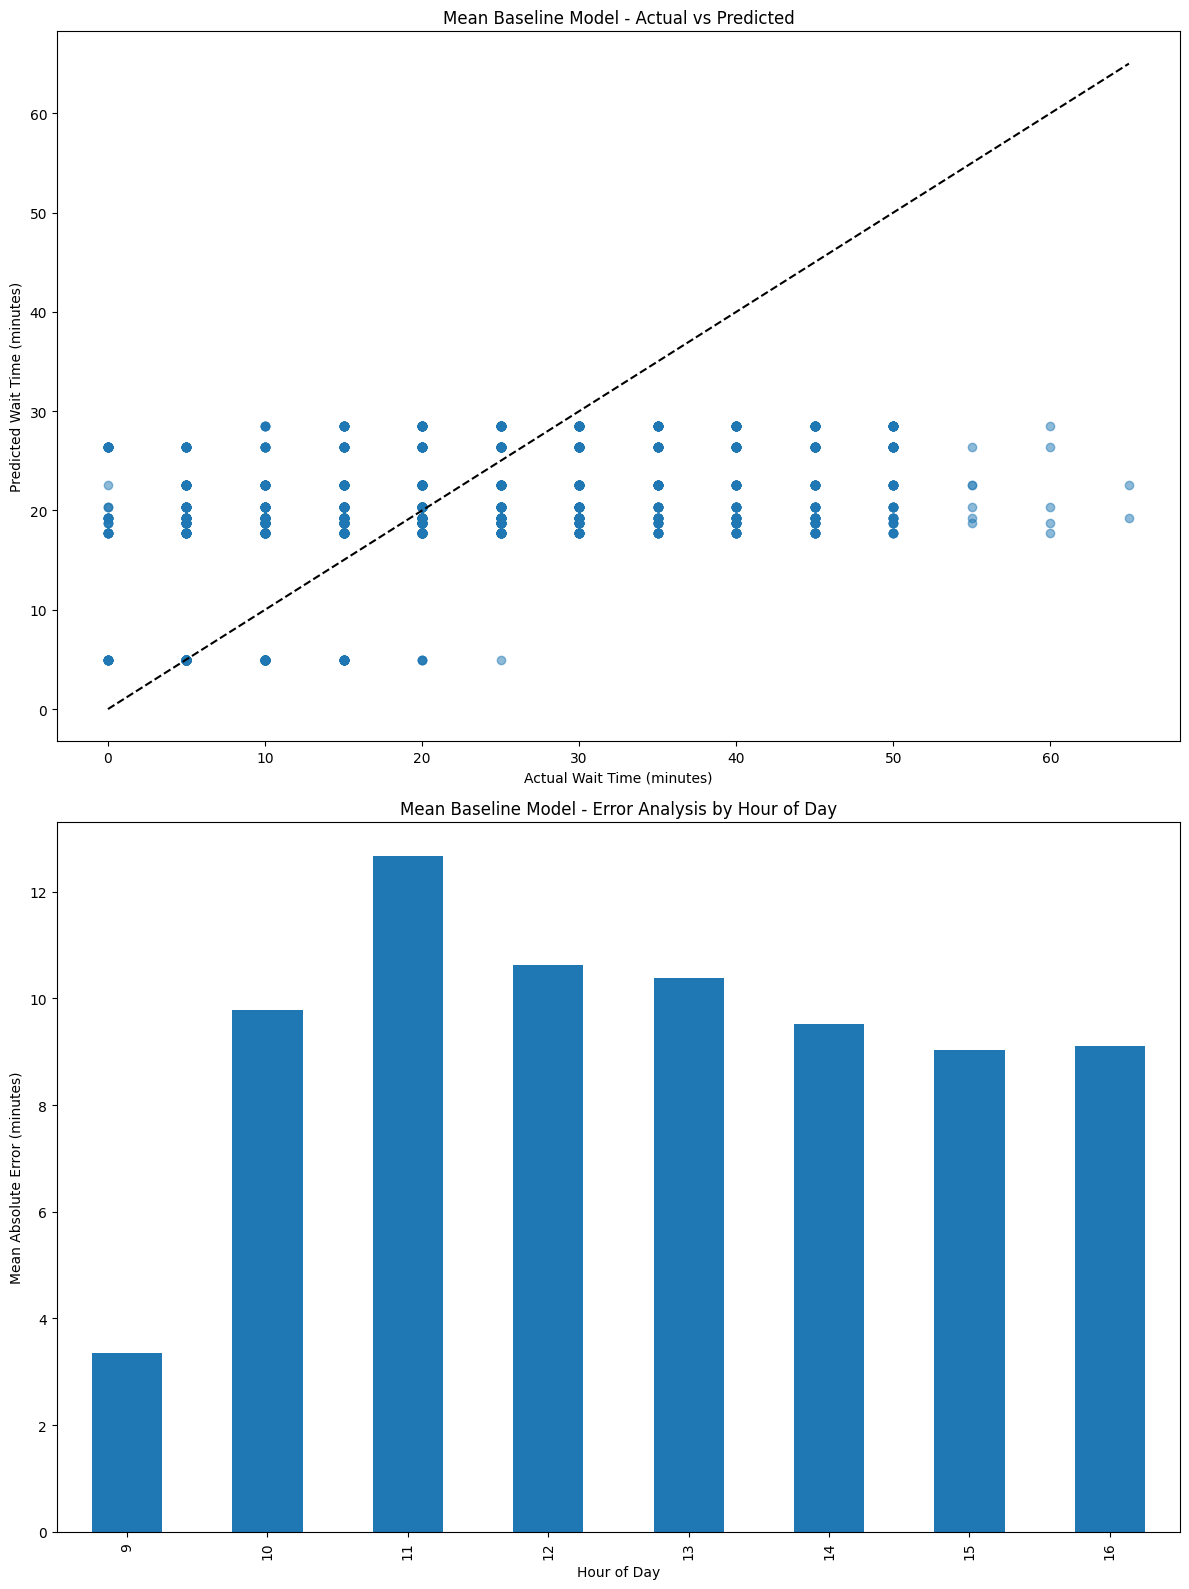

In [ ]:
class TimeOfDayBaselineModel:
    """A baseline model that uses patterns at different times of day."""
    def __init__(self):
        self.time_of_day_means = None
        self.global_mean = None
        
    def fit(self, train_data):
        """Fit the model by calculating mean values for each time of day"""
        # Calculate mean for each time of day
        self.time_of_day_means = train_data.groupby('time_key')['wait_time'].mean().to_dict()
        self.global_mean = train_data['wait_time'].mean()  # Fallback value
        return self
        
    def predict(self, future_df):
        """Predict using time-of-day pattern"""
        predictions = pd.DataFrame({'timestamp': future_df['timestamp']})
        
        # Extract hour and minute from prediction dates
        predictions['hour'] = predictions['timestamp'].dt.hour
        predictions['minute'] = predictions['timestamp'].dt.minute
        predictions['time_key'] = predictions['hour'] * 60 + predictions['minute']
        
        # Assign predictions based on time of day
        predictions['yhat'] = predictions['time_key'].map(
            lambda x: self.time_of_day_means.get(x, self.global_mean))
        
        return predictions[['timestamp', 'yhat']]

# Train and evaluate the Time-of-Day Baseline model
print("\n---- Training Time-of-Day Baseline Model ----")
tod_model = TimeOfDayBaselineModel()
tod_model.fit(train_data)
tod_forecast = tod_model.predict(future)
tod_forecast = post_process_forecast(tod_forecast, val_data)

val_actual = val_data['wait_time'].values
val_predictions = tod_forecast['yhat'].values

metrics, results_df, fig = evaluate_model(val_data, val_actual, val_predictions, title="Time-of-Day Baseline Model")
fig;

## Baseline Model 3: Day-of-Week + Time-of-Day Baseline

This model combines day of week patterns with time of day patterns for more accurate predictions.


---- Training Day-of-Week + Time-of-Day Baseline Model ----

Mean Baseline Model MAE: 8.55 minutes
Mean Baseline Model RMSE: 11.39 minutes
Mean Baseline Model sMAPE: 20.08%


/tmp/ipykernel_25481/293099865.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['day_time_key'] = (train_data['day_of_week'] * 24 * 60 +


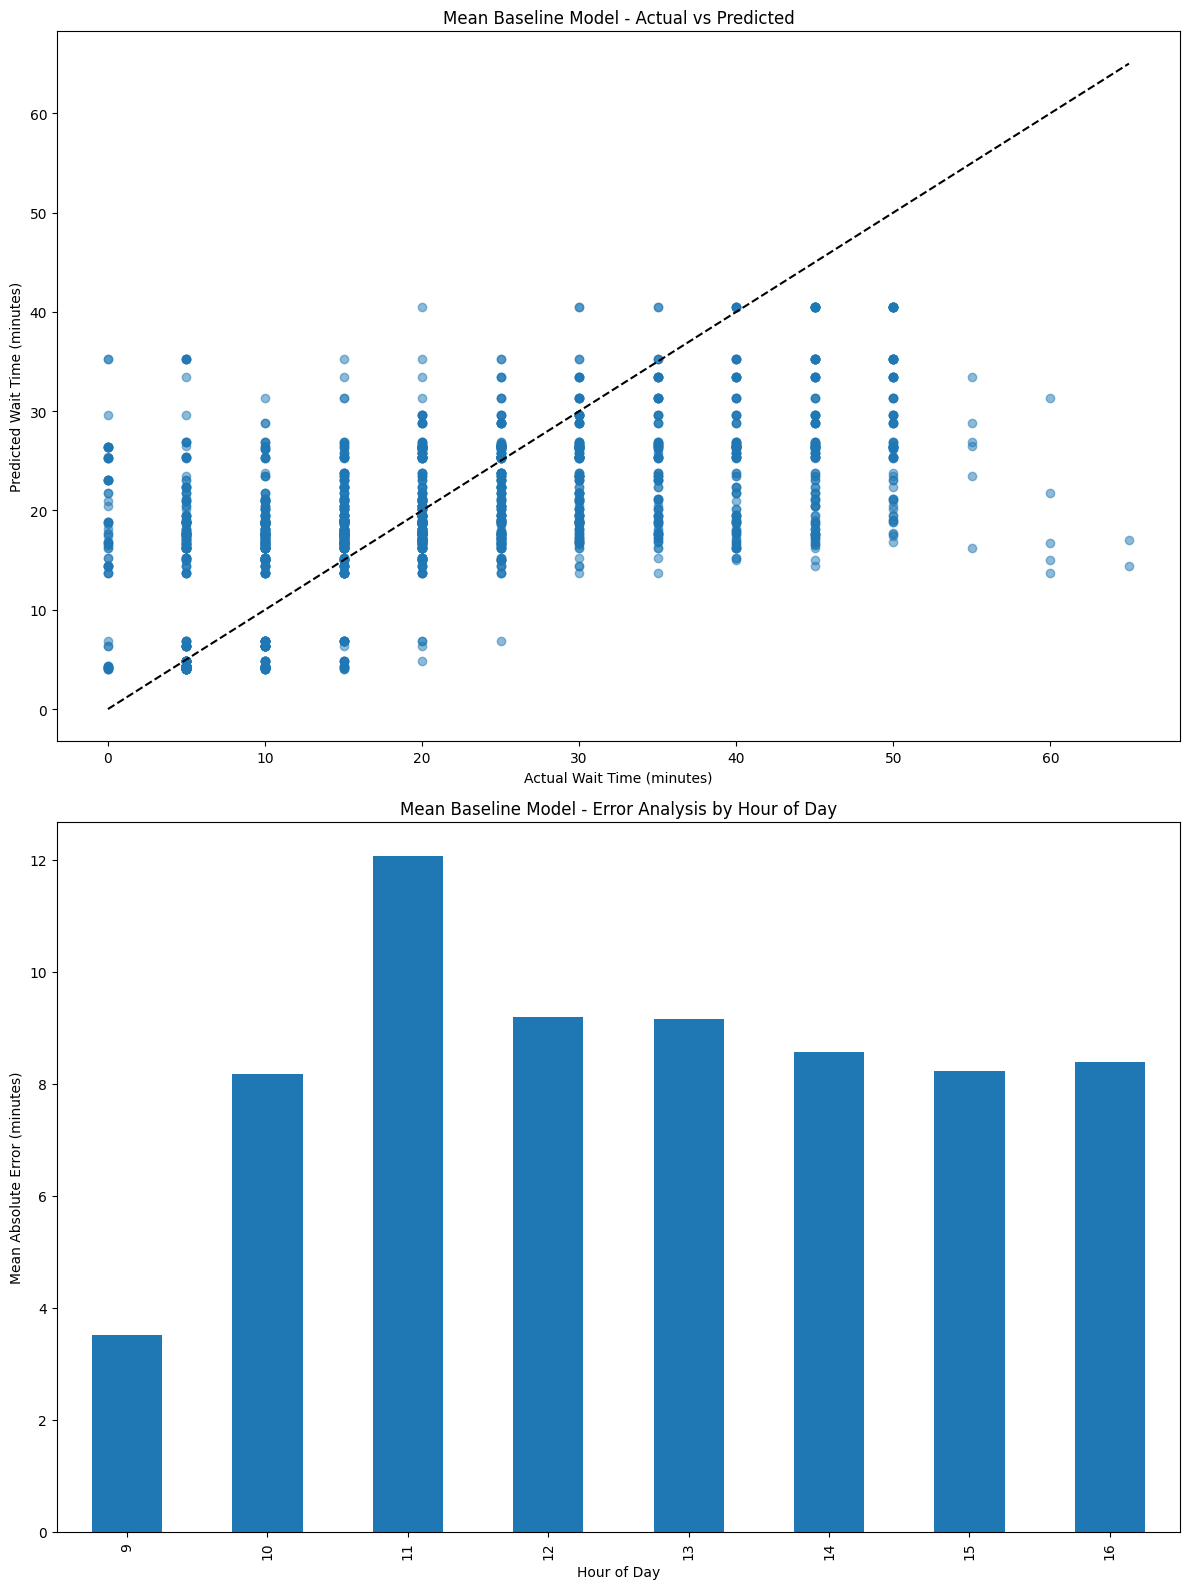

In [ ]:
class DayAndTimeBaselineModel:
    """A model that combines day of week patterns with time of day patterns."""
    def __init__(self):
        self.day_time_means = None
        self.time_means = None
        self.global_mean = None
        
    def fit(self, train_data):
        """Fit the model by calculating mean values for each day+time combination"""
        # Calculate mean for each day and time combination
        train_data['day_time_key'] = (train_data['day_of_week'] * 24 * 60 + 
                                      train_data['time_key'])
        
        self.day_time_means = train_data.groupby('day_time_key')['wait_time'].mean().to_dict()
        self.time_means = train_data.groupby('time_key')['wait_time'].mean().to_dict()
        self.global_mean = train_data['wait_time'].mean()
        self.std_dev = train_data['wait_time'].std()
        
        return self
        
    def predict(self, future_df):
        """Predict using day-of-week and time-of-day patterns"""
        predictions = pd.DataFrame({'timestamp': future_df['timestamp']})
        
        # Extract day of week, hour and minute
        predictions['day_of_week'] = predictions['timestamp'].dt.dayofweek
        predictions['hour'] = predictions['timestamp'].dt.hour
        predictions['minute'] = predictions['timestamp'].dt.minute
        predictions['time_key'] = predictions['hour'] * 60 + predictions['minute']
        predictions['day_time_key'] = (predictions['day_of_week'] * 24 * 60 + 
                                      predictions['time_key'])
        
        # First try to find day+time combination
        predictions['yhat'] = predictions['day_time_key'].map(
            lambda x: self.day_time_means.get(x, None))
        
        # If not found, fall back to time of day
        mask = predictions['yhat'].isna()
        predictions.loc[mask, 'yhat'] = predictions.loc[mask, 'time_key'].map(
            lambda x: self.time_means.get(x, self.global_mean))
                
        return predictions[['timestamp', 'yhat']]

# Train and evaluate the Day+Time Baseline model
print("\n---- Training Day-of-Week + Time-of-Day Baseline Model ----")
day_time_model = DayAndTimeBaselineModel()
day_time_model.fit(train_data)
day_time_forecast = day_time_model.predict(future)
day_time_forecast = post_process_forecast(day_time_forecast, val_data)

val_actual = val_data['wait_time'].values
val_predictions = day_time_forecast['yhat'].values

metrics, results_df, fig = evaluate_model(val_data, val_actual, val_predictions, title="Day+Time Baseline Model")
fig;

## Baseline Model 4: Moving Average Baseline

This model uses the average of recent observations to make predictions.


---- Training Moving Average Baseline Model ----

Mean Baseline Model MAE: 11.43 minutes
Mean Baseline Model RMSE: 13.69 minutes
Mean Baseline Model sMAPE: 25.81%


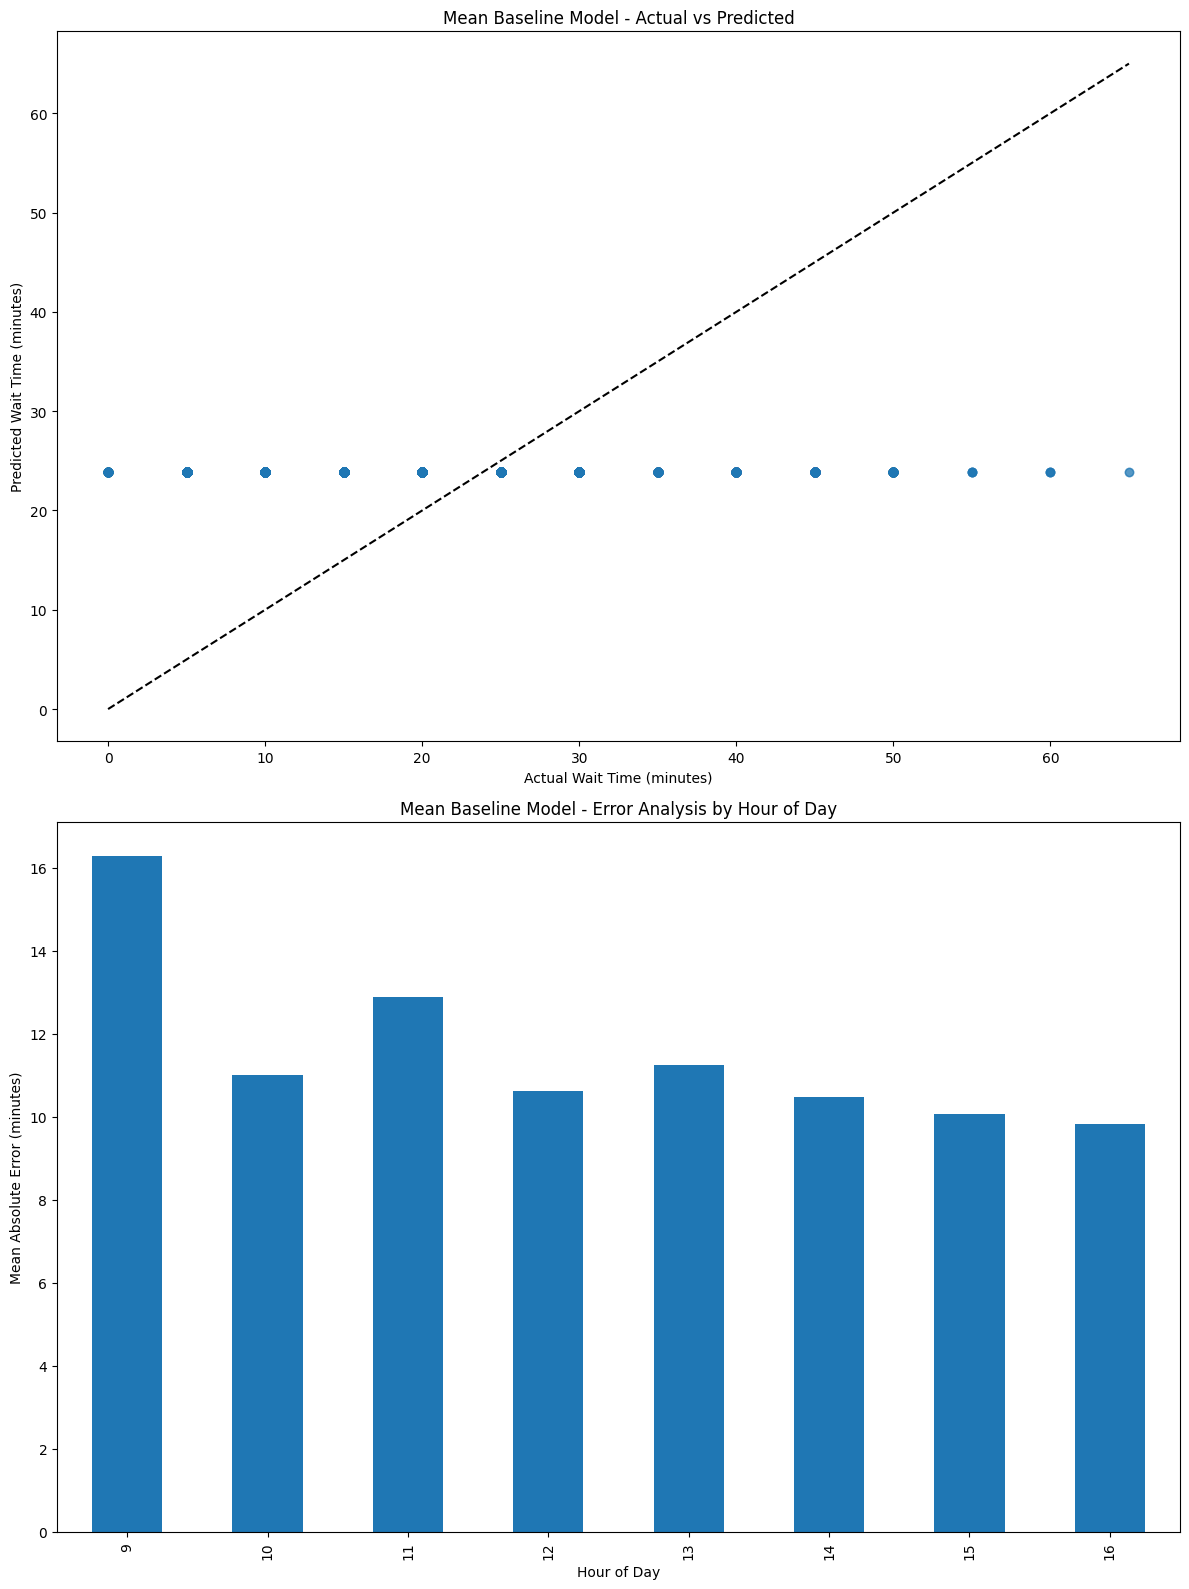

In [ ]:
class MovingAverageBaselineModel:
    """This model uses the average of recent observations for predictions."""
    def __init__(self, window_size=48):  # Default: 1 day (48 30-min intervals)
        self.window_size = window_size
        self.historical_data = None
        self.global_mean = None
        self.std_dev = None
        
    def fit(self, train_data):
        """Store the training data for later prediction"""
        # Make a copy and reset index to avoid ambiguity issues
        self.historical_data = train_data.copy().reset_index(drop=True)
        self.global_mean = self.historical_data['wait_time'].mean()
        self.std_dev = self.historical_data['wait_time'].std()
        return self
        
    def predict(self, future_df):
        """Predict using moving average of recent observations"""
        # Create a copy of future_df with reset index
        future_copy = future_df.copy().reset_index(drop=True)
        predictions = pd.DataFrame({'timestamp': future_copy['timestamp']})
        
        # Create lists for predictions and confidence intervals
        yhat = []
        
        # Sort historical data by date
        sorted_history = self.historical_data.sort_values('timestamp').reset_index(drop=True)
        
        # For each prediction date, calculate the moving average
        for pred_date in predictions['timestamp']:
            # Find recent observations (before the prediction date)
            recent_data = sorted_history[sorted_history['timestamp'] < pred_date].tail(self.window_size)
            
            if len(recent_data) > 0:
                # Calculate the mean of recent observations
                pred_value = recent_data['wait_time'].mean()
            else:
                # Fallback to global mean if no recent data
                pred_value = self.global_mean
                
            # Store prediction and confidence interval
            yhat.append(pred_value)
        
        # Add predictions to dataframe
        predictions['yhat'] = yhat
        
        return predictions

# Train and evaluate the Moving Average Baseline model
print("\n---- Training Moving Average Baseline Model ----")
ma_model = MovingAverageBaselineModel(window_size=48)  # 1 day = 48 30-min intervals
ma_model.fit(train_data)
ma_forecast = ma_model.predict(future)
ma_forecast = post_process_forecast(ma_forecast, val_data)

val_actual = val_data['wait_time'].values
val_predictions = ma_forecast['yhat'].values

metrics, results_df, fig = evaluate_model(val_data, val_actual, val_predictions, title="Moving Average Baseline Model")
fig;

## Baseline Model 5: Seasonal Weekly Pattern Model

This model leverages weekly patterns by using data from the same day and time in previous weeks.



---- Training Seasonal Weekly Pattern Model ----

Mean Baseline Model MAE: 11.31 minutes
Mean Baseline Model RMSE: 15.31 minutes
Mean Baseline Model sMAPE: 29.20%


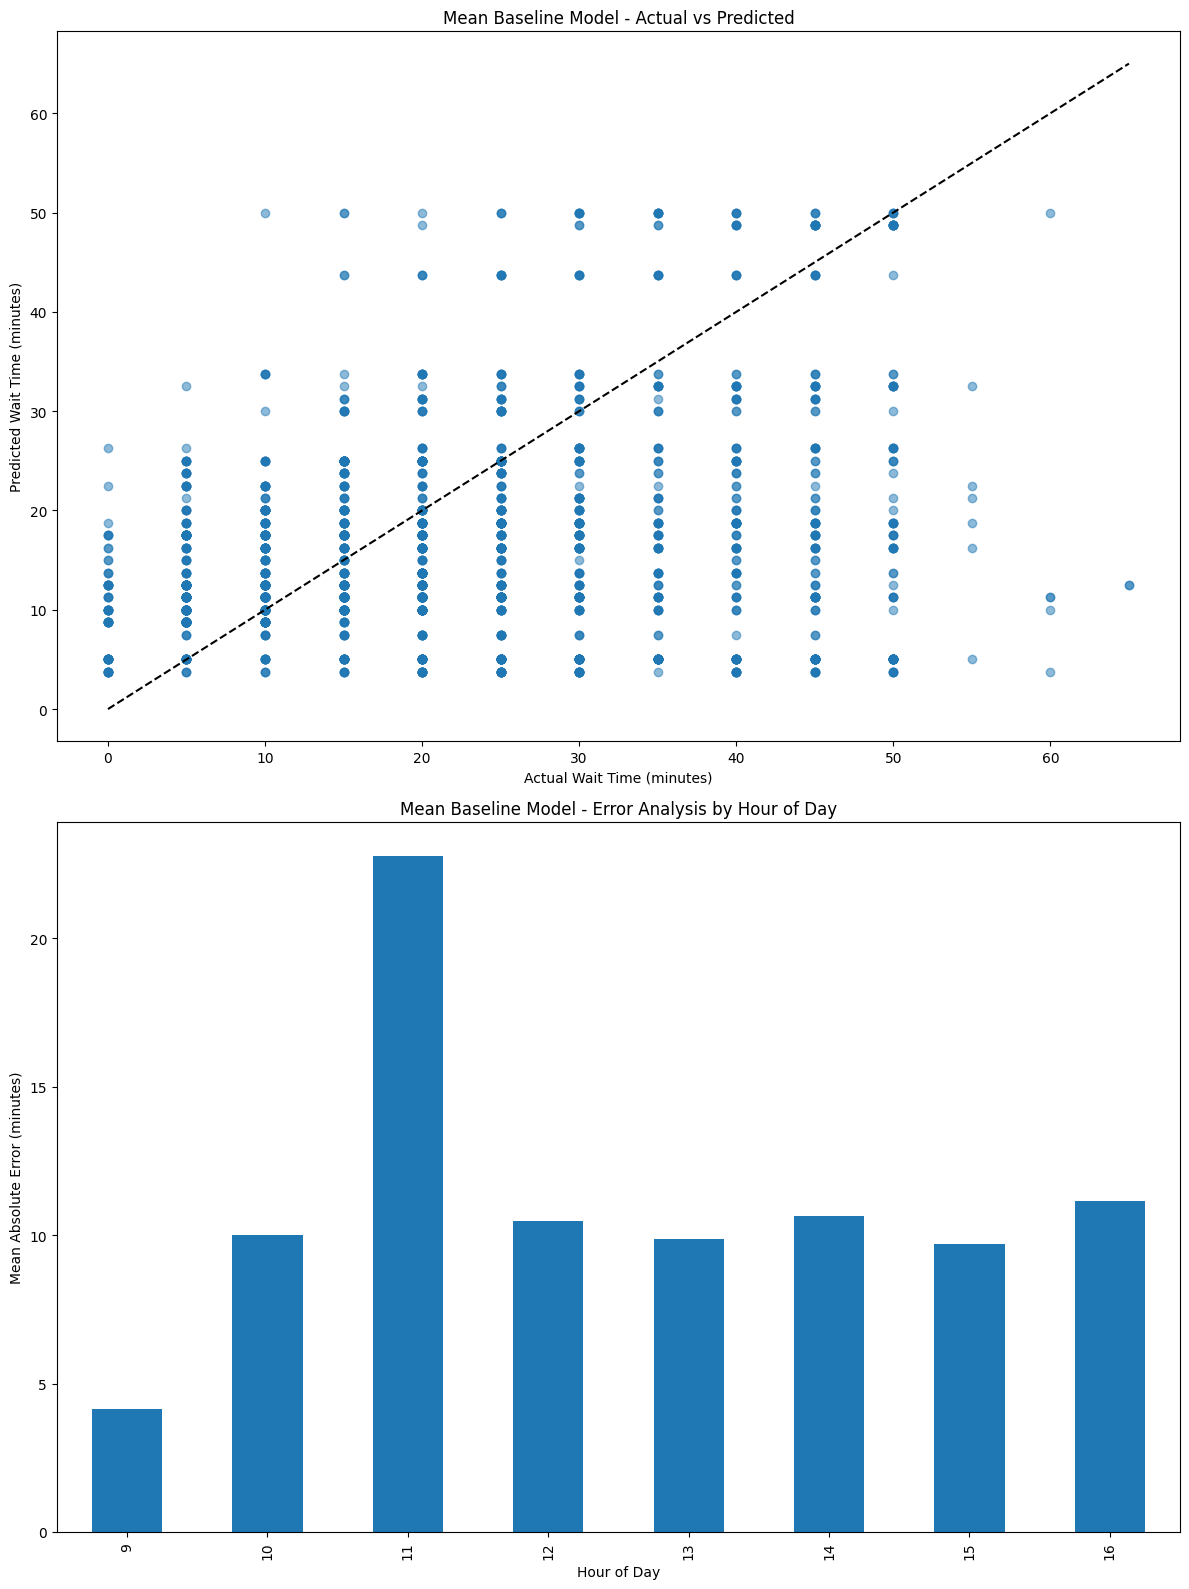

In [ ]:
class SeasonalWeeklyBaselineModel:
    """This model uses data from the same day and time in previous weeks."""
    def __init__(self, num_weeks=4):
        self.num_weeks = num_weeks
        self.training_data = None
        self.global_mean = None
        self.std_dev = None
        
    def fit(self, train_data):
        """Store the training data for later prediction"""
        # Make a copy and reset index to avoid ambiguity issues
        self.training_data = train_data.copy().reset_index(drop=True)
        self.global_mean = self.training_data['wait_time'].mean()
        self.std_dev = self.training_data['wait_time'].std()
        
        # Pre-calculate time features for training data
        self.training_data['day_of_week'] = self.training_data['timestamp'].dt.dayofweek
        self.training_data['hour'] = self.training_data['timestamp'].dt.hour
        self.training_data['minute'] = self.training_data['timestamp'].dt.minute
        self.training_data['time_key'] = self.training_data['hour'] * 60 + self.training_data['minute']
        
        return self
        
    def predict(self, future_df):
        """Predict using the same day of week and time of day from previous weeks"""
        # Create a copy of future_df with reset index
        future_copy = future_df.copy().reset_index(drop=True)
        predictions = pd.DataFrame({'timestamp': future_copy['timestamp']})
        
        # Extract day of week and time for predictions
        predictions['day_of_week'] = predictions['timestamp'].dt.dayofweek
        predictions['hour'] = predictions['timestamp'].dt.hour
        predictions['minute'] = predictions['timestamp'].dt.minute
        predictions['time_key'] = predictions['hour'] * 60 + predictions['minute']
        
        # Predict for each point based on same day/time from previous weeks
        yhat = []
        
        for _, row in predictions.iterrows():
            # Find matching day and time in training data
            matches = self.training_data[
                (self.training_data['day_of_week'] == row['day_of_week']) & 
                (self.training_data['time_key'] == row['time_key'])
            ].copy().reset_index(drop=True)
            
            # Sort by date (descending) and take most recent num_weeks
            if len(matches) > 0:
                matches = matches.sort_values('timestamp', ascending=False).reset_index(drop=True)
                matches = matches.head(self.num_weeks)
                
                # Calculate prediction and confidence interval
                pred = matches['wait_time'].mean()
                yhat.append(pred)
            else:
                # Fallback to global mean if no matches
                yhat.append(self.global_mean)
        
        # Add predictions to dataframe
        predictions['yhat'] = yhat
        
        return predictions[['timestamp', 'yhat']]

# Train and evaluate the Seasonal Weekly Pattern model
print("\n---- Training Seasonal Weekly Pattern Model ----")
weekly_model = SeasonalWeeklyBaselineModel(num_weeks=4)
weekly_model.fit(train_data)
weekly_forecast = weekly_model.predict(future)
weekly_forecast = post_process_forecast(weekly_forecast, val_data)

val_actual = val_data['wait_time'].values
val_predictions = weekly_forecast['yhat'].values

metrics, results_df, fig = evaluate_model(val_data, val_actual, val_predictions, title="Seasonal Weekly Pattern Baseline Model")
fig;

## Baseline Model 6: Holiday-Aware Baseline

This model uses different patterns for holidays and normal days.


---- Training Holiday-Aware Baseline Model ----

Mean Baseline Model MAE: 8.60 minutes
Mean Baseline Model RMSE: 11.41 minutes
Mean Baseline Model sMAPE: 20.22%


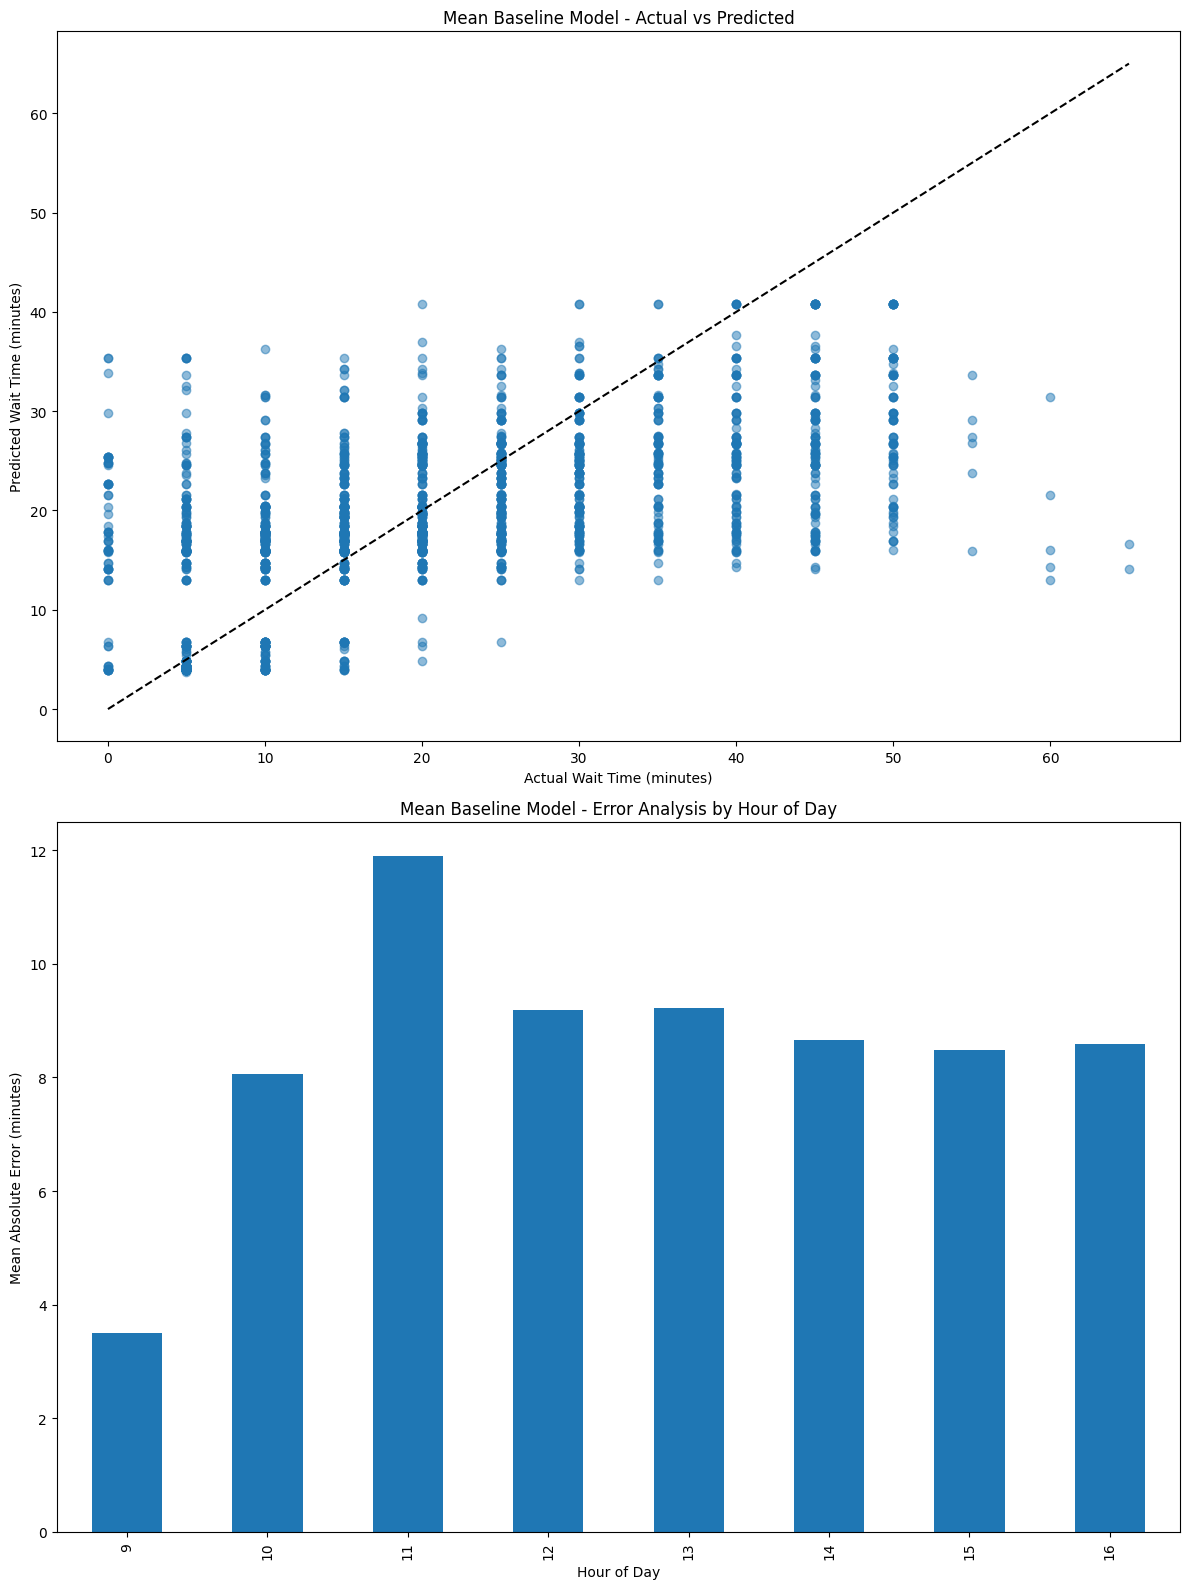

In [ ]:
class HolidayAwareBaselineModel:
    """A model that uses different patterns for holidays and normal days."""
    def __init__(self):
        self.holiday_day_time_means = None
        self.normal_day_time_means = None
        self.holiday_time_means = None
        self.normal_time_means = None
        self.holiday_mean = None
        self.normal_mean = None
        self.global_mean = None
        
    def fit(self, train_data, holiday_data):
        """Fit separate models for holidays and normal days"""
        # Mark holiday days
        holiday_dates = set(pd.to_datetime(holiday_data['timestamp']).dt.date)
        train_data = train_data.copy()
        train_data['is_holiday'] = train_data['timestamp'].dt.date.isin(holiday_dates)
        
        # Create day-time keys if they don't exist yet
        if 'day_time_key' not in train_data.columns:
            train_data['day_time_key'] = (train_data['day_of_week'] * 24 * 60 + 
                                         train_data['time_key'])
        
        # Calculate means for holiday days
        holiday_data = train_data[train_data['is_holiday']]
        self.holiday_day_time_means = holiday_data.groupby('day_time_key')['wait_time'].mean().to_dict()
        self.holiday_time_means = holiday_data.groupby('time_key')['wait_time'].mean().to_dict()
        
        # Calculate means for normal days
        normal_data = train_data[~train_data['is_holiday']]
        self.normal_day_time_means = normal_data.groupby('day_time_key')['wait_time'].mean().to_dict()
        self.normal_time_means = normal_data.groupby('time_key')['wait_time'].mean().to_dict()
        
        # Global means as fallback
        self.holiday_mean = holiday_data['wait_time'].mean() if len(holiday_data) > 0 else train_data['wait_time'].mean()
        self.normal_mean = normal_data['wait_time'].mean() if len(normal_data) > 0 else train_data['wait_time'].mean()
        self.global_mean = train_data['wait_time'].mean()
        self.std_dev = train_data['wait_time'].std()
        
        return self
        
    def predict(self, future_df, holiday_data):
        """Predict using different models for holidays and normal days"""
        predictions = pd.DataFrame({'timestamp': future_df['timestamp']})
        
        # Extract day and time features
        predictions['day_of_week'] = predictions['timestamp'].dt.dayofweek
        predictions['hour'] = predictions['timestamp'].dt.hour
        predictions['minute'] = predictions['timestamp'].dt.minute
        predictions['time_key'] = predictions['hour'] * 60 + predictions['minute']
        predictions['day_time_key'] = (predictions['day_of_week'] * 24 * 60 + 
                                      predictions['time_key'])
        
        # Mark holiday days
        holiday_dates = set(pd.to_datetime(holiday_data['timestamp']).dt.date)
        predictions['is_holiday'] = predictions['timestamp'].dt.date.isin(holiday_dates)
        
        # Initialize predictions
        predictions['yhat'] = np.nan
        
        # Predict for holiday days
        holiday_mask = predictions['is_holiday']
        
        # First try day+time for holidays
        predictions.loc[holiday_mask, 'yhat'] = predictions.loc[holiday_mask, 'day_time_key'].map(
            lambda x: self.holiday_day_time_means.get(x, None))
        
        # Fall back to time of day for holidays
        still_na = holiday_mask & predictions['yhat'].isna()
        predictions.loc[still_na, 'yhat'] = predictions.loc[still_na, 'time_key'].map(
            lambda x: self.holiday_time_means.get(x, self.holiday_mean))
        
        # Predict for normal days
        normal_mask = ~predictions['is_holiday']
        
        # First try day+time for normal days
        predictions.loc[normal_mask, 'yhat'] = predictions.loc[normal_mask, 'day_time_key'].map(
            lambda x: self.normal_day_time_means.get(x, None))
        
        # Fall back to time of day for normal days
        still_na = normal_mask & predictions['yhat'].isna()
        predictions.loc[still_na, 'yhat'] = predictions.loc[still_na, 'time_key'].map(
            lambda x: self.normal_time_means.get(x, self.normal_mean))
        
        # Final fallback to global mean
        still_na = predictions['yhat'].isna()
        predictions.loc[still_na, 'yhat'] = self.global_mean
        
        return predictions[['timestamp', 'yhat']]

# Train and evaluate the Holiday-Aware Baseline model
print("\n---- Training Holiday-Aware Baseline Model ----")
holiday_model = HolidayAwareBaselineModel()
holiday_model.fit(train_data, holidays_df)
holiday_forecast = holiday_model.predict(future, holidays_df)
holiday_forecast = post_process_forecast(holiday_forecast, val_data)

val_actual = val_data['wait_time'].values
val_predictions = holiday_forecast['yhat'].values

metrics, results_df, fig = evaluate_model(val_data, val_actual, val_predictions, title="Holiday-Aware Baseline Model")
fig;

## Baseline Model 7: Last Week Persistence Model

This model predicts the exact value from 7 days ago.


---- Training True Last Week Persistence Model ----

Mean Baseline Model MAE: 8.45 minutes
Mean Baseline Model RMSE: 12.31 minutes
Mean Baseline Model sMAPE: 19.53%


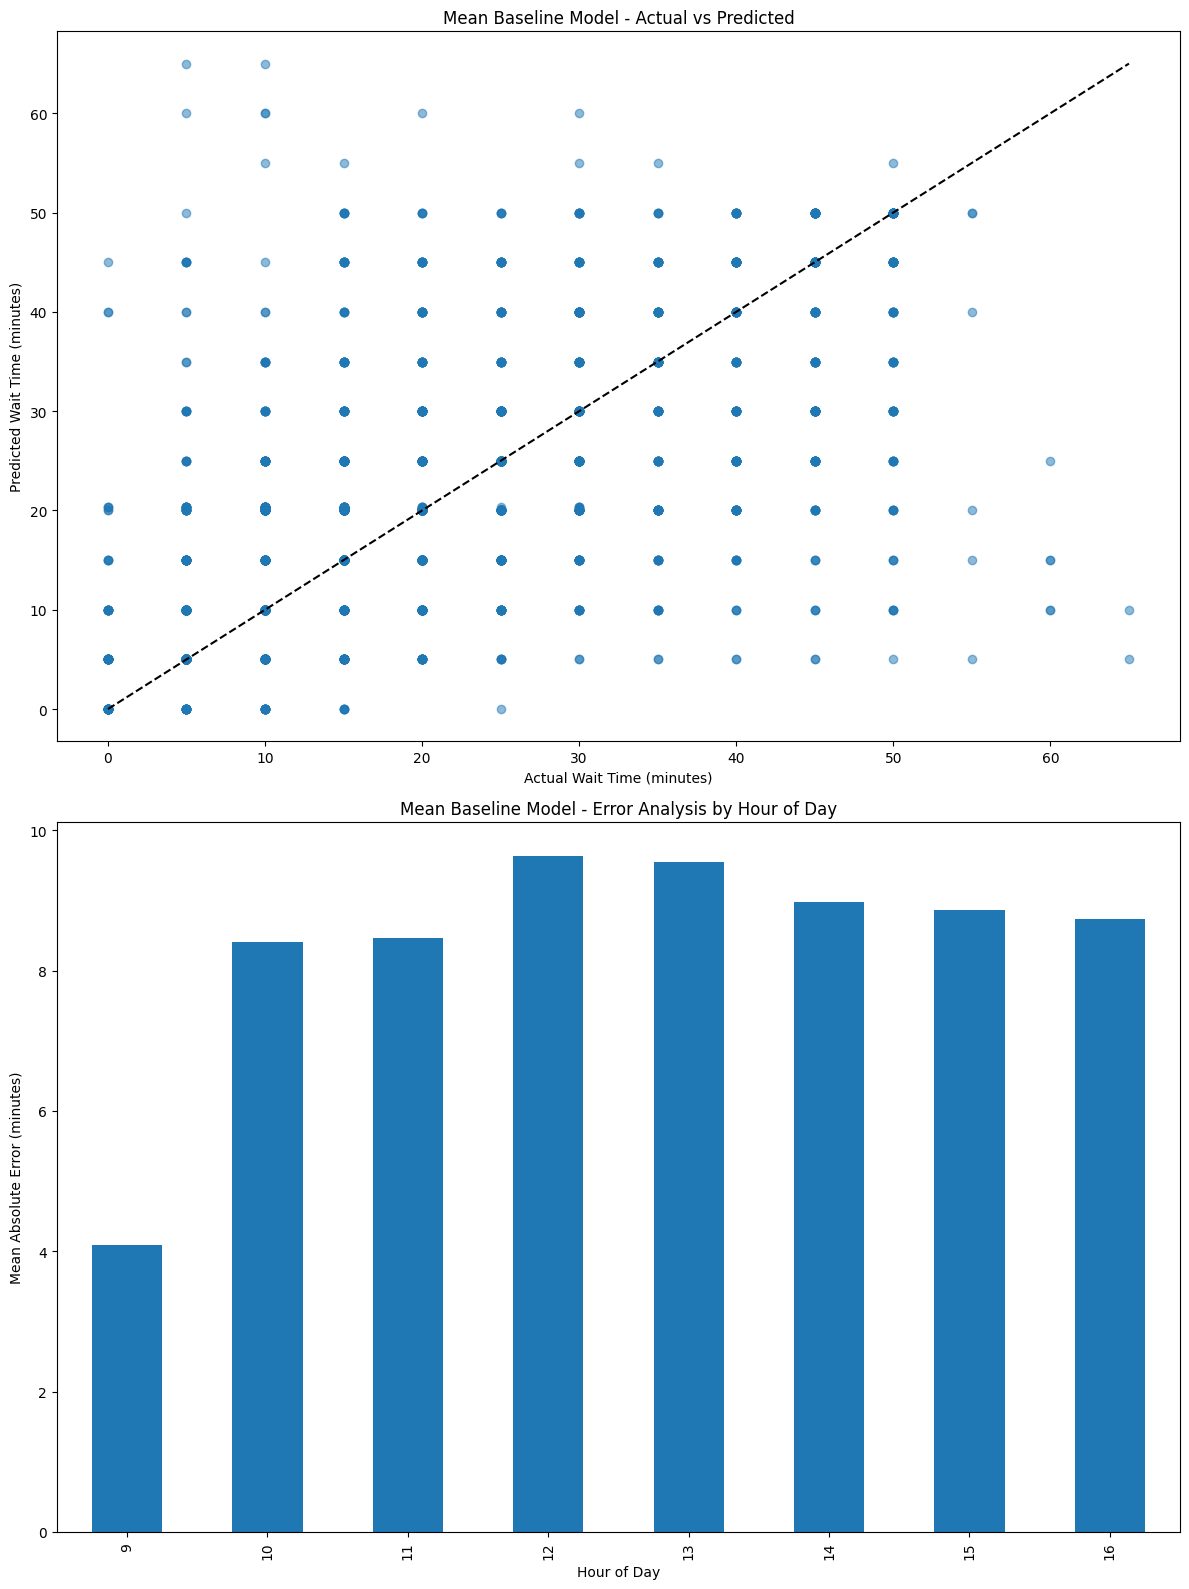

In [ ]:
class TrueLastWeekModel:
    """A model that uses the exact value from 7 days before in the same dataset."""
    def __init__(self):
        self.train_data = None
        self.std_dev = None
        
    def fit(self, train_data):
        """Store training data"""
        self.train_data = train_data.copy().reset_index(drop=True)
        self.train_data_dict = dict(zip(self.train_data['timestamp'], self.train_data['wait_time']))
        self.std_dev = self.train_data['wait_time'].std()
        self.global_mean = self.train_data['wait_time'].mean()
        return self
        
    def predict(self, future_df, val_data=None):
        """Predict using values from 7 days before in the same dataset"""
        predictions = pd.DataFrame({'timestamp': future_df['timestamp']})
        yhat = []
        
        # Create value lookup dictionaries
        if val_data is not None:
            val_data = val_data.copy().reset_index(drop=True)
            val_data_dict = dict(zip(val_data['timestamp'], val_data['wait_time']))
        
        # For each prediction date
        for date in predictions['timestamp']:
            last_week = date - pd.Timedelta(days=7)
            
            # For validation dates, first check in validation data
            if val_data is not None and date in val_data['timestamp'].values:
                if last_week in val_data_dict:
                    yhat.append(val_data_dict[last_week])
                else:
                    # If no exact match, use global mean
                    yhat.append(self.global_mean)
            # For training dates, check in training data
            else:
                if last_week in self.train_data_dict:
                    yhat.append(self.train_data_dict[last_week])
                else:
                    # If no exact match, use global mean
                    yhat.append(self.global_mean)
        
        # Add predictions and confidence intervals
        predictions['yhat'] = yhat
        
        return predictions[['timestamp', 'yhat']]

# Train and evaluate the True Last Week model
print("\n---- Training True Last Week Persistence Model ----")
lastweek_model = TrueLastWeekModel()
lastweek_model.fit(train_data)

# This time, pass both future dataframe and validation data
lastweek_forecast = lastweek_model.predict(future, val_data)
lastweek_forecast = post_process_forecast(lastweek_forecast, val_data)

val_actual = val_data['wait_time'].values
val_predictions = lastweek_forecast['yhat'].values

metrics, results_df, fig = evaluate_model(val_data, val_actual, val_predictions, title="LastWeek Baseline Model")
fig;

## Baseline Model 8: LastYear Baseline Model

This model predicts the wait time from exactly 365 days ago. It uses annual persistence rather than weekly persistence.


---- Training LastYear Model (Same Day of Week) ----

LastYear Model (Same Day of Week) MAE: 9.02 minutes
LastYear Model (Same Day of Week) RMSE: 13.02 minutes
LastYear Model (Same Day of Week) sMAPE: 21.15%


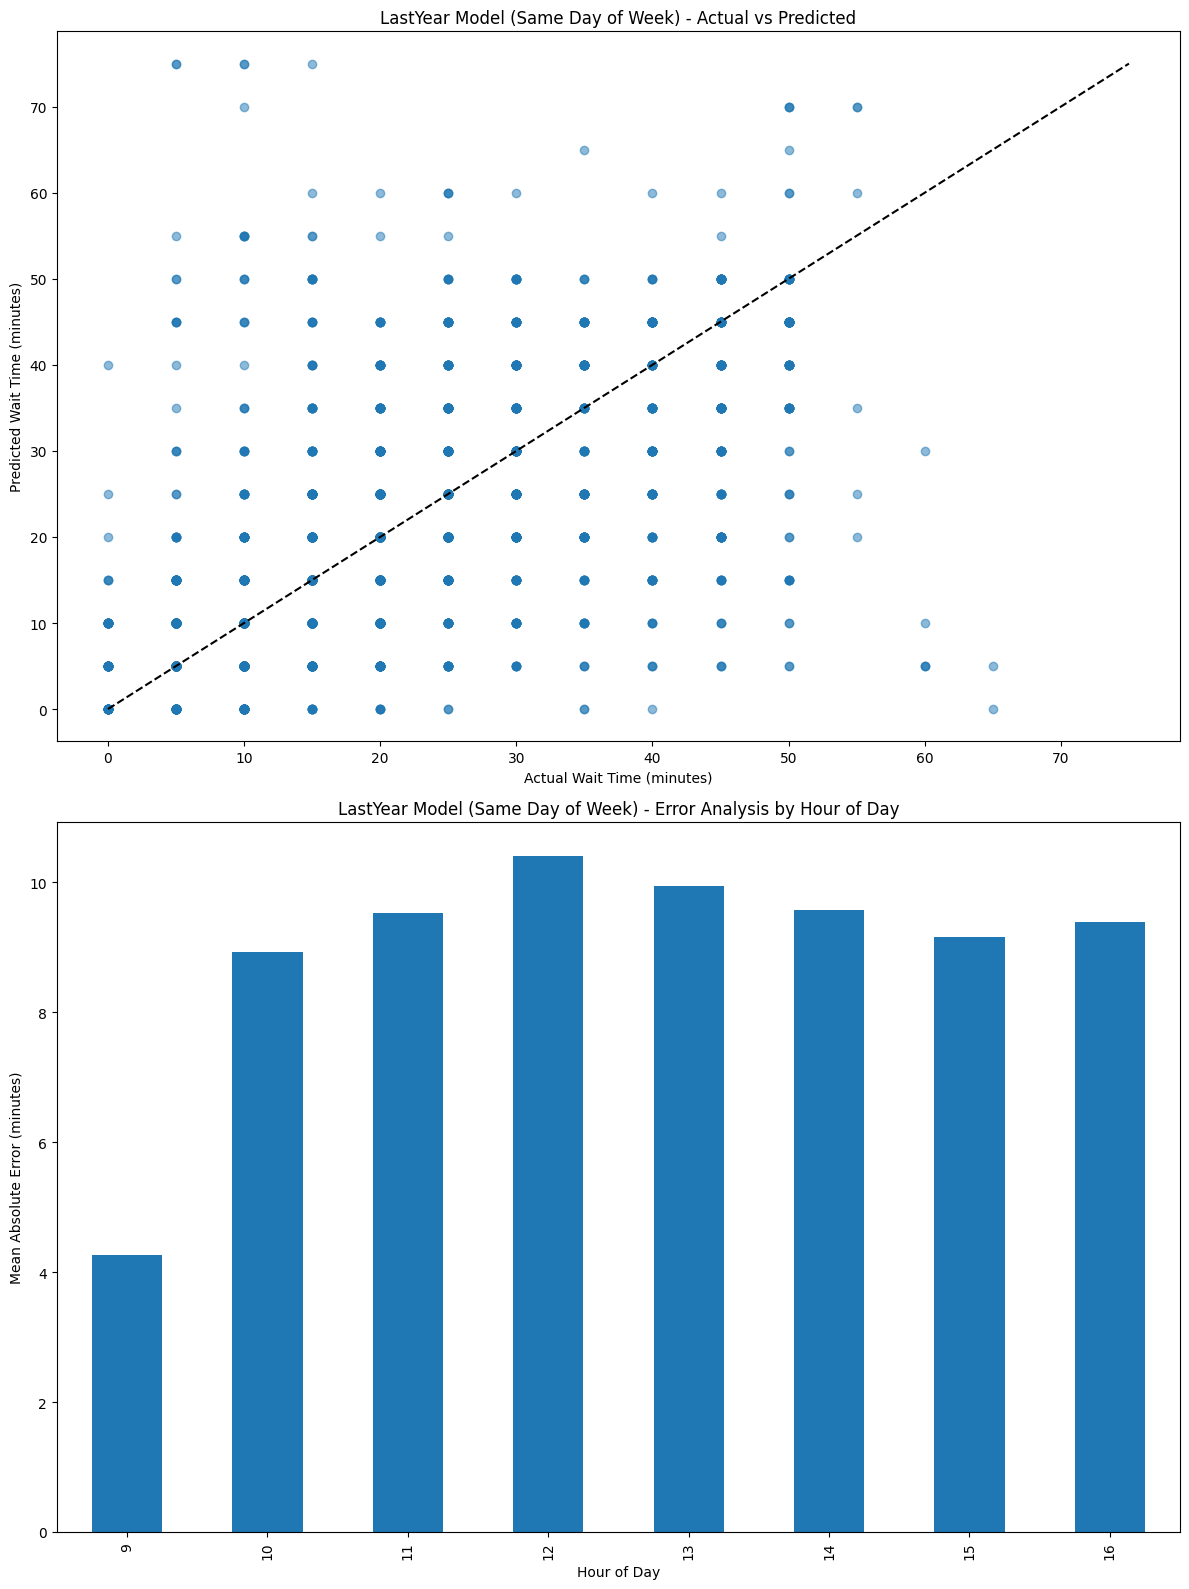

In [ ]:
class LastYearModel:
    """A baseline that uses the value from the same day of the week in the previous year."""
    def __init__(self):
        self.historical_data = None
        self.std_dev = None
        
    def fit(self, train_data):
        """Store the training data indexed by timestamp"""
        self.historical_data = train_data.copy().reset_index(drop=True)
        # Create a lookup dictionary for fast access
        self.date_to_value = dict(zip(self.historical_data['timestamp'], self.historical_data['wait_time']))
        self.std_dev = self.historical_data['wait_time'].std()
        self.global_mean = self.historical_data['wait_time'].mean()
        return self
    
    def _get_same_day_previous_year(self, date):
        """Get the same day of the week from the previous year, handling leap years."""
        # Start with the same date last year
        try:
            same_date_last_year = date.replace(year=date.year - 1)
        except ValueError:
            # Handle Feb 29 in leap years - move to Feb 28
            same_date_last_year = date.replace(year=date.year - 1, day=28)
        
        # Calculate the difference in days of the week
        current_weekday = date.weekday()
        last_year_weekday = same_date_last_year.weekday()
        
        # Adjust to get the same day of the week
        days_diff = current_weekday - last_year_weekday
        target_date = same_date_last_year + pd.Timedelta(days=days_diff)
        
        return target_date
        
    def predict(self, future_df):
        """Predict using the same day of the week from the previous year"""
        predictions = pd.DataFrame({'timestamp': future_df['timestamp']})
        yhat = []
        
        for date in predictions['timestamp']:
            # Get the same day of the week from previous year
            target_date = self._get_same_day_previous_year(date)
            
            # If we have data for that exact date, use it
            if target_date in self.date_to_value:
                yhat.append(self.date_to_value[target_date])
            else:
                # Look for closest date within a 7-day window (prefer same weekday)
                closest_date = None
                min_diff = pd.Timedelta(days=7)
                
                for historical_date in self.date_to_value.keys():
                    diff = abs(historical_date - target_date)
                    # Prefer dates with the same weekday
                    if historical_date.weekday() == date.weekday():
                        diff = diff - pd.Timedelta(hours=1)  # Small bias towards same weekday
                    
                    if diff < min_diff:
                        min_diff = diff
                        closest_date = historical_date
                
                if closest_date is not None:
                    yhat.append(self.date_to_value[closest_date])
                else:
                    # Otherwise use global mean
                    yhat.append(self.global_mean)
                
        predictions['yhat'] = yhat
        
        return predictions

# Train and evaluate the LastYear model
print("\n---- Training LastYear Model (Same Day of Week) ----")
lastyear_model = LastYearModel()
lastyear_model.fit(train_data)
lastyear_forecast = lastyear_model.predict(future)
lastyear_forecast = post_process_forecast(lastyear_forecast, val_data)

val_actual = val_data['wait_time'].values
val_predictions = lastyear_forecast['yhat'].values

metrics, results_df, fig = evaluate_model(val_data, val_actual, val_predictions, title="LastYear Model (Same Day of Week)")
fig;